# Reinforcement Learning Project


## Requirements

In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0
import gym
import os
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt

TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 9.1MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [ ]:
%load_ext tensorboard

##  Environment

In [ ]:
# Param, Reward Func, Terminal State TBD
import gym
import os
import gym
from gym import spaces
import numpy as np
import random

class PandemicEnv(gym.Env):
    def reset(self):
        # reward
        self.reward = 0

        # step count
        self.day = 0

        # economy available
        self.economy = 1

        # times used for each resource: Do Noting, Home isolation, Mobile cabin hospital isolation
        # Close school (partial), Close work place (partial), Close public traffic (partial), Lockdown
        # Test, research
        self.times = np.array([10000, 10, 5, 3, 3, 3, 1, 20, 5])

        # speed param
        self.Infectivity = 0.2
        self.deathRate = 0.03
        self.researchSpeed = 0.002
        self.mutation = 0.01
        self.exposure = 50
        self.Recovery_rate = 0.05

        # stats
        self.population = 1000000.
        self.people = 1000000.
        self.infected = 10000
        self.dead = 0.
        self.researched = 0.
        self.recovery = 0.

        # increase param
        self.param1 = 0.15

        obs = np.array([self.Infectivity,
                         self.deathRate,
                         self.researchSpeed,
                         self.mutation,
                         self.people/self.population,
                         self.infected/self.population,
                         self.dead/self.population,
                         self.recovery/self.population,
                         self.researched,
                         self.economy/self.max_economy,
                        self.exposure/self.max_exposure,
                        self.Recovery_rate,
                        self.day/500.])
        resource = self.times/self.max_resources
        obs = np.concatenate([obs, resource], axis=0)

        obs.squeeze()

        return obs

    def __init__(self):
        # set action/observation spaces
        # 13 choices
        self.action_space = spaces.Discrete(13)
        self.action_name = ['Do Noting', 'Home isolation', 'Mobile cabin hospital isolation',
                            'Close school (partial)', 'Close work place (partial)', ' Close public traffic (partial)',
                            'Open public traffic (partial)', 'Open work place (partial)', ' Open school (partial)',
                            'Lockdown', 'Open Lockdown', 'Partial test', 'Complete test', 'Invest in R&D']

        # self.Infectivity, self.deathRate, self.researchSpeed, self.mutation, self.people, self.infected, self.dead, self.recovery, self.researched, self.economy, 
        # self.exposure, self.Recovery_rate, self.times
        self.max_economy = 1
        self.max_exposure = 50
        self.max_resources = np.array([np.infty, 10, 5, 3, 3, 3, 1, 20, 5])


        self.max_bos = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
        self.observation_space = spaces.Box(low=0, high=self.max_bos, shape=(22,), dtype=np.float32)
        # action matrix: Infectivity, deathRate, researchSpeed, cost, exposure, recover rate, # of uses, resource
        self.matrix = np.zeros([14, 8], dtype=np.float)
        self.effect = np.array([0.1, 0.1, 0.005, 0.005, 1, 0.1, 1, 1])

        self.matrix[0] = np.array([0, 0, 0, 0, 0, 0, 0, 0])       # Do Noting
        self.matrix[1] = np.array([-1, 1, 0, -1, -1, 0, -1, 1])  # Home isolation
        self.matrix[2] = np.array([-2, -2, 0, -2, -2, 2, -1, 2])   # Mobile cabin hospital isolation
        self.matrix[3] = np.array([-1, 0, -2, -2, -0.5, 0, -1, 3])   # Close school (partial)
        self.matrix[4] = np.array([-2, 0, -1, -5, -5, 0, -1, 4])   # Close work place (partial)
        self.matrix[5] = np.array([-3, 0, 0, -5, -5, 0, -1, 5])    # Close public traffic (partial)
        self.matrix[6] = np.array([3, 0, 0, 4, 4, 0, 1, 5])       # Open public traffic (partial)
        self.matrix[7] = np.array([2, 0, 1, 3, 4, 0, 1, 4])       # Open work place (partial)
        self.matrix[8] = np.array([1, 0, 1, 1, 0.5, 0, 1, 3])       # Open school (partial)
        self.matrix[9] = np.array([-9, -3, -2, -60, -40, 2, -1, 6])  # Lockdown
        self.matrix[10] = np.array([9, 3, 1, 40, 30, -2, 1, 6])      # Open lockdown
        self.matrix[11] = np.array([-1, -1, 0, -1, 0, 1, -1, 7])  # Partial test
        self.matrix[12] = np.array([-3, -2, 2, -5, 0, 2, -2, 7]) # Complete test
        self.matrix[13] = np.array([0, 0, 6, -4, 0, 0, -1, 8])  # Invest in R&D

        self.matrix = np.array([1, 1, 1, 0, 1, 1, 0, 0]) + self.matrix * self.effect

        self.reset()

        #self.action_space.update_action(self.times)

    def actionUpdate(self, action, test):
        panish = 0
        resource = int(self.matrix[action, -1])
        self.times[resource] += self.matrix[action, -2]
        cost = self.matrix[action, 3] #* (self.day ** self.param1)

        # Check if illegal
        if self.times[resource] > self.max_resources[resource]:
            self.times[resource] -= self.matrix[action, -2]
            action = 0
            cost = np.abs(cost) * -1
            panish = -15
            if test:
              print("outof bound")
        elif self.times[resource] < 0:
            self.times[resource] -= self.matrix[action, -2]
            action = 0
            cost = np.abs(cost) * -1
            panish = -15
            if test:
              print("smaller bound")
        
        #self.action_space.update_action(self.times)


        # Update param
        self.Infectivity *= self.matrix[action][0]
        self.deathRate *= self.matrix[action][1]
        self.researchSpeed *= self.matrix[action][2]
        self.exposure *= self.matrix[action][4]
        self.Recovery_rate *= self.matrix[action][5]
        self.researched += self.researchSpeed

        # Mutation
        m = random.choices(population=[0, 1], weights=[self.mutation, 1 - self.mutation])
        if m == 0:
            self.Infectivity += np.random.normal(0, 0.02)
            self.deathRate += np.random.normal(0, 0.02)
            self.researchSpeed += np.random.normal(0, 0.002)
            self.mutation += np.random.normal(0, 0.001)

        # Sanitation check
        self.Infectivity = np.clip(self.Infectivity, 0, 1)
        self.deathRate = np.clip(self.deathRate, 0, 1)
        self.researchSpeed = np.clip(self.researchSpeed, 0, 1)
        self.mutation = np.clip(self.mutation, 0, 1)
        self.exposure = np.clip(self.exposure, 0, 1)
        self.Recovery_rate = np.clip(self.Recovery_rate, 0, 1)

        # Update Death
        newDeath = np.clip(self.infected * self.deathRate + np.random.normal(0, 10), 0, self.infected)
        self.people -= newDeath
        self.infected -= newDeath
        self.dead += newDeath

        # Update Infected and Recovery
        exposure = self.exposure * (1 - (self.recovery + self.infected) / self.people) + se
        newInfected = np.clip(exposure * self.infected * self.Infectivity + np.random.normal(0, 50), 0, self.people-(self.recoverylf.infected))
        newRecovery = np.clip(self.infected * self.Recovery_rate + np.random.normal(0, 40), 0, self.infected)
        self.infected += newInfected - newRecovery
        self.recovery += newRecovery

        # Update Research
        newresearched = np.clip(self.researchSpeed * (self.people-self.infected)/self.population + np.random.normal(0, 0.001), 0, 1-self.researched)
        self.researched += newresearched

        # Undate economy
        self.economy += cost
        if newInfected / self.people > 0.001:
          self.economy -= newInfected * 0.000001
          cost -= newInfected * 0.000001
        if self.dead / self.population > 0.3:
          self.max_economy = 0.7
          if self.economy > 0.7:
            cost -= self.economy - 0.7
            self.economy = 0.7  

        return cost, newDeath, newInfected, newresearched, newRecovery, panish

    def step(self, action, test=False):
        # update param
        cost, newDeath, newInfected, newresearched, newRecovery, panish = self.actionUpdate(action, test)

        # step count increase
        self.day += 1

        # reward function
        reward = newresearched * 2 + cost + (-newInfected * 15 - newDeath * 30 + newRecovery)/self.population + np.random.normal(0,0.1)

        if self.dead / self.population > 0.1:
          reward -= self.dead / self.population
        if self.infected / self.people > 0.005:
          reward -= self.infected / self.people * 10
        if self.economy < 0.2 or self.people/self.population <= 0.1:
          reward -= 5
        if self.researched >= 1 or (self.recovery+self.infected)>=self.people:
            reward += 5
        if self.infected < 10:
          reward += 0.5 * (10-self.infected)
        if newInfected < 1 and self.day<30:
          reward += 0.5
        
        reward += panish

        # allow a maximum number of attempts or reach max score
        done = False
        if (self.researched >= 1) or (self.day >= 500) or (self.people/self.population <= 0.1) or (self.economy <= 0.2) or (self.recovery+self.infected >= self.people) or self.infected <= 0:
            done = True
            if test:
              print("\n Research: {}; Day: {}; People: {}; Economy: {}".format(self.researched, self.day, self.people/self.population, self.economy))

        obs = np.array([self.Infectivity + np.random.normal(0, 0.001),
                        self.deathRate + np.random.normal(0, 0.001),
                        self.researchSpeed + np.random.normal(0, 0.001),
                        self.mutation + np.random.normal(0, 0.001),
                        self.people/self.population + np.random.normal(0, 0.001),
                        self.infected/self.population + np.random.normal(0, 0.001),
                        self.dead/self.population + np.random.normal(0, 0.001),
                        self.recovery/self.population + np.random.normal(0, 0.001),
                        self.researched + np.random.normal(0, 0.001),
                        self.economy/self.max_economy + np.random.normal(0, 0.001),
                        self.exposure/self.max_exposure + np.random.normal(0, 0.001),
                        self.Recovery_rate + np.random.normal(0, 0.001),
                        self.day/500.])
        resource = self.times/self.max_resources
        obs = np.concatenate([obs, resource], axis=0)
        
        obs = np.clip(obs, 0, self.max_bos)
        obs.squeeze()

        return obs, reward, done, {}

### Action space

In [ ]:
class pandemic_action(spaces.Discrete):
    def update_action(self, resource):
        self.available_actions = [0]
        if resource[1] > 0:
            self.available_actions.append(1)
        if resource[2] > 0:
            self.available_actions.append(2)
        if resource[3] > 0:
            self.available_actions.append(3)
        if resource[4] > 0:
            self.available_actions.append(4)
        if resource[5] > 0:
            self.available_actions.append(5)
        if resource[6] > 0:
            self.available_actions.append(9)
        if resource[7] > 0:
            self.available_actions.append(11)
        if resource[7] > 1:
            self.available_actions.append(12)
        if resource[8] > 0:
            self.available_actions.append(13)
        
        if resource[3] < 3:
            self.available_actions.append(8)
        if resource[4] < 3:
            self.available_actions.append(7)
        if resource[5] < 3:
            self.available_actions.append(6)
        if resource[6] < 1:
            self.available_actions.append(10)
        
        
    def sample(self):
        return np.random.choice(self.available_actions)

    def contains(self, x):
        return x in self.available_actions

## Testing the Environment

Step 1
Action:  Lockdown
obs= [0.0211 0.0215 0.0023 0.01   1.     0.0003 0.0004 0.0015 0.0025 0.6997
 0.0013 0.0595 0.002  0.     1.     1.     1.     1.     1.     0.
 1.     1.    ] reward= -0.3515216339372438 done= False
Step 2
Action:  Home isolation
obs= [0.0183 0.0241 0.0033 0.0098 1.     0.     0.0009 0.0001 0.0062 0.695
 0.0013 0.0585 0.004  0.     0.9    1.     1.     1.     1.     0.
 1.     1.    ] reward= -0.5972159910654267 done= False
Step 3
Action:  Close school (partial)
obs= [0.015  0.0236 0.0008 0.0105 1.     0.0014 0.     0.     0.0132 0.6844
 0.     0.0603 0.006  0.     0.9    1.     0.6667 1.     1.     0.
 1.     1.    ] reward= -0.48834959979080017 done= False
Step 4
Action:  Close school (partial)
obs= [0.0154 0.0233 0.0026 0.0096 0.9994 0.     0.001  0.0006 0.017  0.6757
 0.0002 0.0594 0.008  0.     0.9    1.     0.3333 1.     1.     0.
 1.     1.    ] reward= -0.6511521649986679 done= False
Step 5
Action:  Invest in R&D
obs= [0.0163 0.022  0.0026 0.009  1.    

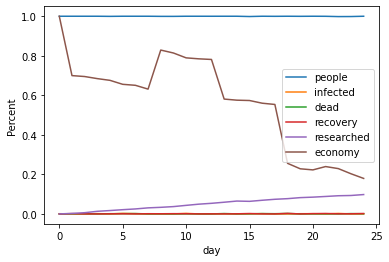

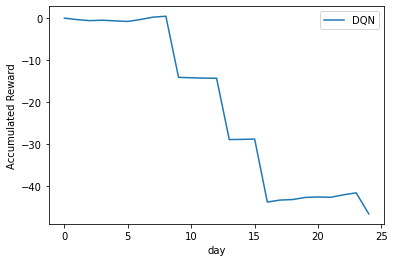

In [ ]:
import random
from stable_baselines.common.env_checker import check_env
env = PandemicEnv()

# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)
obs = env.reset()

space = [i for i in range(env.matrix.shape[0])]

obs = np.squeeze(obs)
people = [obs[4]]
infected = [obs[5]]
dead = [obs[6]]
recovery = [obs[7]]
researched = [obs[8]]
economy = [obs[9]]
acc_reward = [0]

for step in range(1000):
  action = random.choice(space)
  print("Step {}".format(step + 1))
  print("Action: ", env.action_name[action])
  obs, reward, done, info = env.step(action, True)
  obs = np.squeeze(obs)
  people.append(obs[4])
  infected.append(obs[5])
  dead.append(obs[6])
  recovery.append(obs[7])
  researched.append(obs[8])
  economy.append(obs[9])
  acc_reward.append(reward + acc_reward[-1])
  with np.printoptions(precision=4, suppress=True):
    pass
    print('obs=', obs, 'reward=', acc_reward[-1], 'done=', done)
  if done:
    print("Finished!", "reward=", acc_reward)
    break
  # print("Day: %i, Action: %s, Infectivity: %s, deathRate: %s, researchSpeed: %s, people: %s, infected: %s, dead: %s, researched: %s, points: %s, reward: %s, done: %s" % (step, action, observation[0], observation[1], observation[2], observation[3], observation[4], observation[5], observation[6], observation[7], reward, done))
  # if done: break
# #, Infectivity: %s, deathRate: %s, researchSpeed: %s, people: %s, infected: %s, dead: %s, researched: %s, reward: %s, done: %s
# # , observation[0], observation[1], observation[2], observation[3], observation[4], observation[5], observation[6], reward, done
x = np.arange(0, len(people))
plt.figure(1)
plt.plot(x, people, label='people')
plt.plot(x, infected, label='infected')
plt.plot(x, dead, label='dead')
plt.plot(x, recovery, label='recovery')
plt.plot(x, researched, label='researched')
plt.plot(x, economy, label='economy')
plt.ylabel('Percent')
plt.xlabel('day')
plt.legend()
plt.savefig('random.jpg')

x1 = np.arange(0, len(acc_reward))
plt.figure(2)
plt.plot(x1, acc_reward, label='DQN')
plt.ylabel('Accumulated Reward')
plt.xlabel('day')
plt.legend()
plt.show()

## DQN

In [ ]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.deepq.policies import LnMlpPolicy

# Instantiate the env
env = PandemicEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1)
# Train the agent
model = DQN(LnMlpPolicy, env, verbose=1, tensorboard_log="./Run/", exploration_fraction=0.2, exploration_final_eps=0.1)
model.learn(total_timesteps=20000, tb_log_name="DQN")

--------------------------------------
| % time spent exploring  | 38       |
| episodes                | 100      |
| mean 100 episode reward | -60.7    |
| steps                   | 2739     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 200      |
| mean 100 episode reward | -21.4    |
| steps                   | 6726     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 300      |
| mean 100 episode reward | 1.3      |
| steps                   | 10167    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 400      |
| mean 100 episode reward | 0.6      |
| steps                   | 14399    |
--------------------------------------
--------------------------------------
| % time spent exploring 

Step 1 Action:  Home isolation
Step 2 Action:   Close public traffic (partial)
Step 3 Action:  Home isolation
Step 4 Action:  Home isolation
Step 5 Action:  Home isolation
Step 6 Action:   Close public traffic (partial)
Step 7 Action:  Home isolation
Step 8 Action:  Home isolation
Step 9 Action:  Home isolation
Step 10 Action:  Home isolation
Step 11 Action:  Open public traffic (partial)
Step 12 Action:   Close public traffic (partial)
Step 13 Action:  Open public traffic (partial)
Step 14 Action:   Close public traffic (partial)
Step 15 Action:  Open public traffic (partial)
Step 16 Action:   Close public traffic (partial)
Step 17 Action:  Open public traffic (partial)
Step 18 Action:   Close public traffic (partial)
Step 19 Action:  Open public traffic (partial)
Step 20 Action:   Close public traffic (partial)
Step 21 Action:  Open public traffic (partial)
Step 22 Action:   Close public traffic (partial)
Step 23 Action:  Open public traffic (partial)
Step 24 Action:   Close public t

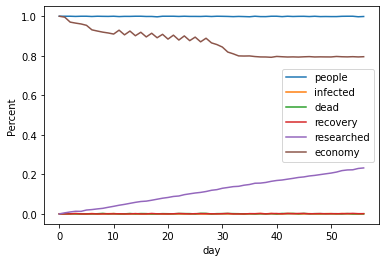

In [ ]:
# Test the trained agent
env = PandemicEnv()
obs = env.reset()

n_steps = 1000
obs = np.squeeze(obs)
people = [obs[4]]
infected = [obs[5]]
dead = [obs[6]]
recovery = [obs[7]]
researched = [obs[8]]
economy = [obs[9]]
acc_reward = [0]

for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action, True)
  obs = np.squeeze(obs)
  people.append(obs[4])
  infected.append(obs[5])
  dead.append(obs[6])
  recovery.append(obs[7])
  researched.append(obs[8])
  economy.append(obs[9])
  acc_reward.append(reward + acc_reward[-1])
  if action:
    print("Step {}".format(step + 1), end=' ')
    print("Action: ", env.action_name[action])
    #with np.printoptions(precision=4, suppress=True):
      #print('obs=', obs, 'reward=', reward)
  if done:
    print("Goal reached!", "reward=", acc_reward[-1])
    break

x = np.arange(0, len(people))
plt.figure(1)
plt.plot(x, people, label='people')
plt.plot(x, infected, label='infected')
plt.plot(x, dead, label='dead')
plt.plot(x, recovery, label='recovery')
plt.plot(x, researched, label='researched')
plt.plot(x, economy, label='economy')
plt.ylabel('Percent')
plt.xlabel('day')
plt.legend()
plt.savefig('DQN2.jpg')
plt.show()

## A2C

In [ ]:
from stable_baselines import A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.policies import MlpPolicy

env = PandemicEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

model2 = A2C(MlpPolicy, env, verbose=1, tensorboard_log="./Run/")
model2.learn(total_timesteps=15000, tb_log_name="A2C")

---------------------------------
| explained_variance | 0.003    |
| fps                | 30       |
| nupdates           | 1        |
| policy_entropy     | 2.56     |
| policy_loss        | -93.8    |
| total_timesteps    | 20       |
| value_loss         | 1.61e+03 |
---------------------------------
---------------------------------
| ep_len_mean        | 8.01     |
| ep_reward_mean     | -37.3    |
| explained_variance | 0.32     |
| fps                | 332      |
| nupdates           | 100      |
| policy_entropy     | 1.02     |
| policy_loss        | 0.905    |
| total_timesteps    | 2000     |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| ep_len_mean        | 10.4     |
| ep_reward_mean     | -48.6    |
| explained_variance | 0.423    |
| fps                | 346      |
| nupdates           | 200      |
| policy_entropy     | 1.19     |
| policy_loss        | 3        |
| total_timesteps    | 4000     |
| value_loss  

Step 1 Action:  Home isolation

 Research: 0.1628231956058738; Day: 43; People: 0.9993787639091566; Economy: 0.995
Goal reached! reward= 4.9297047028351075


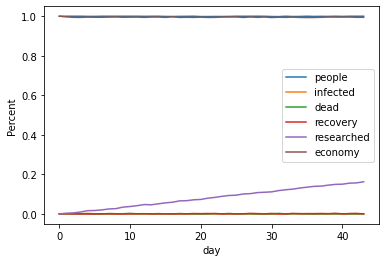

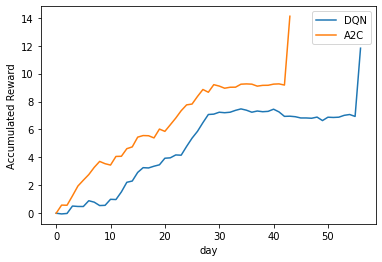

In [ ]:
env = PandemicEnv()

# Test the trained agent
obs = env.reset()
n_steps = 1000
obs = np.squeeze(obs)

people = [obs[4]]
infected = [obs[5]]
dead = [obs[6]]
recovery = [obs[7]]
researched = [obs[8]]
economy = [obs[9]]
acc_reward2 = [0]

for step in range(n_steps):
  action, _ = model2.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action, test=True)
  obs = np.squeeze(obs)
  people.append(obs[4])
  infected.append(obs[5])
  dead.append(obs[6])
  recovery.append(obs[7])
  researched.append(obs[8])
  economy.append(obs[9])
  acc_reward2.append(reward + acc_reward2[-1])
  if action:
    print("Step {}".format(step + 1), end=' ')
    print("Action: ", env.action_name[action])
    #with np.printoptions(precision=4, suppress=True):
      #print('obs=', obs[5:8], 'reward=', reward, 'done=', done)
  if done:
    print("Goal reached!", "reward=", reward)
    break

x = np.arange(0, len(people))
plt.figure(1)
plt.plot(x, people, label='people')
plt.plot(x, infected, label='infected')
plt.plot(x, dead, label='dead')
plt.plot(x, recovery, label='recovery')
plt.plot(x, researched, label='researched')
plt.plot(x, economy, label='economy')
plt.ylabel('Percent')
plt.xlabel('day')
plt.legend()
plt.savefig('acktr2.jpg')

x1 = np.arange(0, len(acc_reward))
x2 = np.arange(0, len(acc_reward2))
plt.figure(2)
plt.plot(x1, acc_reward, label='DQN')
plt.plot(x2, acc_reward2, label='A2C')
plt.ylabel('Accumulated Reward')
plt.xlabel('day')
plt.legend()
plt.savefig('reward2.jpg')
plt.show()

In [ ]:
%tensorboard --logdir ./Run/

UsageError: Line magic function `%tensorboard` not found.


## GMEZO

In [ ]:
class ReinforcementLearning:
    def __init__(self, mdp):
        self.env = mdp

    def mlp(self, theta1, theta2, obs):
        l1 = np.dot(theta1, obs)
        z = np.maximum(l1, 0)
        out = np.dot(theta2, z)
        return out

    def OffPolicyMC(self, nEpisodes, epsilon=0.1):

        theta1 = np.random.rand(16, 22)
        theta2 = np.random.rand(14, 16, 16)
        w = np.random.rand(16)
        deta = 0.01

        gt1 = 0
        gt2 = 0
        gw = 0

        for e in range(nEpisodes):
            u = np.random.rand(16)
            u = u / np.linalg.norm(u)

            obs = self.env.reset()
            obs = np.squeeze(obs)
            state = [obs]
            action = [0]
            reward = [0]

            done = False

            while not done:
                z = self.mlp(theta1, theta2, obs)
                score = np.dot(z, w + u * deta)
                a = int(np.argmax(score))

                obs, r, done, info = self.env.step(a)
                obs = np.squeeze(obs)

                state.insert(0, obs)
                action.insert(0, a)
                reward.insert(0, r)

            g = 0
            G = 0
            R = 0

            for i in range(len(state) - 1):
                R += reward[i]
                g += R * u / (len(state) - 1 - i)
                G += R * u / (len(state) - 1 - i) * np.sign(w / (self.mlp(theta1, theta2, obs)[action[i]] + 1e-7))

            gw += np.power(g,2)
            w -= 0.01 * g / (gw + 1e-7)

            gt2 += np.power(G, 2)
            theta2 -= 0.01 * G / (gt2 + 1e-7)

            G1 = np.dot(theta1.transpose(),np.maximum(G, 0))
            gt1 += np.power(G1, 2)
            theta1 -= 0.01 * G1 / (gt1 + 1e-7)
            

        self.theta1 = theta1
        self.theta2 = theta2
        self.w = w

    def predict(self, obs):
        z = self.mlp(self.theta1, self.theta2, obs)
        score = np.dot(z, self.w)
        a = int(np.argmax(score))

        return a

In [ ]:
env = PandemicEnv()

model3 = ReinforcementLearning(env)
model3.OffPolicyMC(20000)

outof bound
Step 1 Action:  Open work place (partial)
outof bound
Step 2 Action:  Open work place (partial)
outof bound
Step 3 Action:  Open work place (partial)
outof bound
Step 4 Action:  Open work place (partial)
outof bound
Step 5 Action:  Open work place (partial)
outof bound
Step 6 Action:  Open work place (partial)
outof bound
Step 7 Action:  Open work place (partial)
outof bound
Step 8 Action:  Open work place (partial)
outof bound
Step 9 Action:  Open work place (partial)
outof bound
Step 10 Action:  Open work place (partial)
outof bound
Step 11 Action:  Open work place (partial)
outof bound
Step 12 Action:  Open work place (partial)
outof bound
Step 13 Action:  Open work place (partial)
outof bound
Step 14 Action:  Open work place (partial)
outof bound
Step 15 Action:  Open work place (partial)
outof bound
Step 16 Action:  Open work place (partial)
outof bound
Step 17 Action:  Open work place (partial)
outof bound
Step 18 Action:  Open work place (partial)
outof bound
Step 19

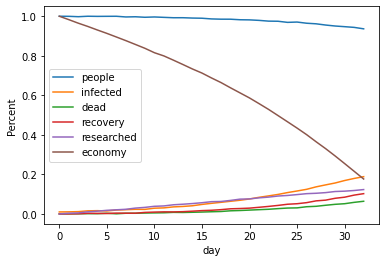

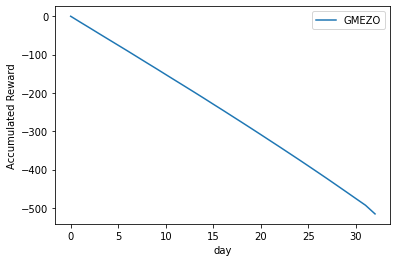

In [ ]:
env = PandemicEnv()

# Test the trained agent
obs = env.reset()
n_steps = 1000
obs = np.squeeze(obs)

people = [obs[4]]
infected = [obs[5]]
dead = [obs[6]]
recovery = [obs[7]]
researched = [obs[8]]
economy = [obs[9]]
acc_reward3 = [0]

for step in range(n_steps):
  action = model3.predict(obs)
  obs, reward, done, info = env.step(action, test=True)
  obs = np.squeeze(obs)
  people.append(obs[4])
  infected.append(obs[5])
  dead.append(obs[6])
  recovery.append(obs[7])
  researched.append(obs[8])
  economy.append(obs[9])
  acc_reward3.append(reward + acc_reward3[-1])
  if action:
    print("Step {}".format(step + 1), end=' ')
    print("Action: ", env.action_name[action])
    #with np.printoptions(precision=4, suppress=True):
      #print('obs=', obs[5:8], 'reward=', reward, 'done=', done)
  if done:
    print("Goal reached!", "reward=", reward)
    break

x = np.arange(0, len(people))
plt.figure(1)
plt.plot(x, people, label='people')
plt.plot(x, infected, label='infected')
plt.plot(x, dead, label='dead')
plt.plot(x, recovery, label='recovery')
plt.plot(x, researched, label='researched')
plt.plot(x, economy, label='economy')
plt.ylabel('Percent')
plt.xlabel('day')
plt.legend()
plt.savefig('acktr2.jpg')

x3 = np.arange(0, len(acc_reward3))
plt.figure(2)
plt.plot(x3, acc_reward3, label='GMEZO')
plt.ylabel('Accumulated Reward')
plt.xlabel('day')
plt.legend()
plt.savefig('reward2.jpg')
plt.show()